In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from math import sqrt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from vecstack import stacking

D:\AnacondaNavigator\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv(r'C:/Users/Venom/Desktop/694560_1215964_bundle_archive/preprocessed_data.csv')

In [3]:
df.shape

(2758800, 12)

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
def train_test_split(data,column,train_start_date, train_end_date,test_start_date,test_end_date):
    train_start_date = pd.to_datetime(train_start_date)
    train_end_date =  pd.to_datetime(train_end_date)
    test_start_date =  pd.to_datetime(test_start_date)
    test_end_date = pd.to_datetime(test_end_date)
    data[column] = pd.to_datetime(data[column])
    train = data.loc[(data[column]>=train_start_date)&(data[column]<=train_end_date)]
    test = data.loc[(data[column]>=test_start_date)&(data[column]<=test_end_date)]
    train.reset_index(drop =True,inplace = True)
    test.reset_index(drop =True,inplace = True)
    return train,test
def get_mape(actual, predicted):
    y_true, y_pred = np.array(actual), np.array(predicted)
    return np.round( np.mean(np.abs((actual - predicted)/ actual)) * 100, 2)

In [6]:
df['prev_day'] = df.groupby('City').AvgTemperature.shift(1)
df['prev_2day'] = df.groupby('City').AvgTemperature.shift(2)
df['prev_3day'] = df.groupby('City').AvgTemperature.shift(3)
df['prev_year'] = df.groupby('City').AvgTemperature.shift(365)
df['prev_2year'] = df.groupby('City').AvgTemperature.shift(365*2)
df['prev_3year'] = df.groupby('City').AvgTemperature.shift(365*3)
df['Season'] = (df.Month%12 + 3)//3

In [7]:
x_train,x_test = train_test_split(df[(df.Region=='North America')].copy(),'Date','1995-01-01','2018-12-30','2018-12-31','2019-12-31')

In [8]:
y_train = x_train.AvgTemperature
y_test = x_test.AvgTemperature

In [9]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1451741, 19), (57035, 19), (1451741,), (57035,))

In [10]:
region_temp_mapper = x_train.groupby('Region').AvgTemperature.mean().to_dict()
country_temp_mapper =  x_train.groupby('Country').AvgTemperature.mean().to_dict()
city_temp_mapper =  x_train.groupby('City').AvgTemperature.mean().to_dict()

In [11]:
x_train['is_neg_percent'] = np.where(x_train.AvgTemperature<0,1,0)
neg_mapper = x_train.groupby('City').apply(lambda x:x.is_neg_percent.mean()*100).to_dict()

In [12]:
x_train['is_neg_percent'] = x_train['City'].map(neg_mapper)
x_test['is_neg_percent'] = x_test['City'].map(neg_mapper)

In [13]:
x_train['Region_enc'] = x_train['Region'].map(region_temp_mapper)
x_test['Region_enc'] = x_test['Region'].map(region_temp_mapper)

x_train['Country_enc'] = x_train['Country'].map(country_temp_mapper)
x_test['Country_enc'] = x_test['Country'].map(country_temp_mapper)

x_train['City_enc'] = x_train['City'].map(city_temp_mapper)
x_test['City_enc'] = x_test['City'].map(city_temp_mapper)

In [14]:
x_train['combined'] = x_train.Country.astype(str)+"_"+x_train.Month.astype(str)
country_month_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['country_month_mean'] = x_train.combined.map(country_month_details)

x_test['combined'] = x_test.Country.astype(str)+"_"+x_test.Month.astype(str)
x_test['country_month_mean'] = x_test.combined.map(country_month_details)


In [15]:
x_train['combined'] = x_train.City.astype(str)+"_"+x_train.Month.astype(str)
city_month_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['city_month_mean'] = x_train.combined.map(city_month_details)

x_test['combined'] = x_test.City.astype(str)+"_"+x_test.Month.astype(str)
x_test['city_month_mean'] = x_test.combined.map(city_month_details)


In [16]:
x_train['combined'] = x_train.City.astype(str)+"_"+x_train.Season.astype(str)
city_season_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['city_season_mean'] = x_train.combined.map(city_season_details)

x_test['combined'] = x_test.City.astype(str)+"_"+x_test.Season.astype(str)
x_test['city_season_mean'] = x_test.combined.map(city_season_details)

In [17]:
x_train.drop('combined',inplace=True,axis = 1)
x_test.drop('combined',inplace=True,axis = 1)

In [18]:
x_train['days_rolling_mean'] = x_train.groupby('City')['AvgTemperature'].rolling(30).mean().reset_index(0,drop=True)
rolling_mean_mapper = x_train.groupby('City').days_rolling_mean.mean().to_dict()
x_test['days_rolling_mean'] = x_test['City'].map(rolling_mean_mapper)

In [19]:
x_train['years_rolling_mean'] = x_train.groupby('City')['AvgTemperature'].rolling(365).mean().reset_index(0,drop=True)
rolling_mean_mapper = x_train.groupby('City').days_rolling_mean.mean().to_dict()
x_test['years_rolling_mean'] = x_test['City'].map(rolling_mean_mapper)

In [20]:
selected = ['Month', 'Longitude', 'dist_from_north', 'prev_year','prev_2year','prev_3year','city_month_mean',
            'days_rolling_mean','years_rolling_mean','is_neg_percent','city_season_mean']
len(selected)

11

In [21]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1451741, 28), (57035, 28), (1451741,), (57035,))

In [22]:
model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=5,
    learning_rate=0.01,
    n_estimators=500,
    subsample_for_bin=200000,
    objective=None,
    class_weight=None,
    min_split_gain=0.0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=69,
    n_jobs=-1,
    silent=True,
    importance_type='split',
)
x_train['weights'] = np.where(x_train.AvgTemperature>10,3,1)
model.fit(x_train[selected].fillna(0,axis = 1),y_train,x_train['weights'] )

LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=500,
              random_state=69)

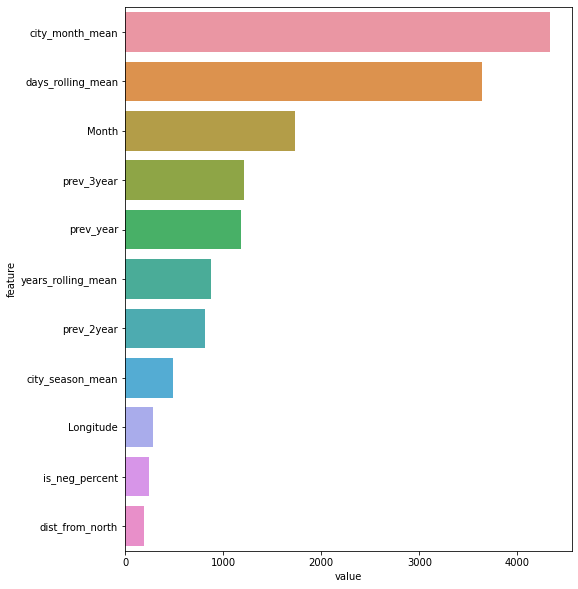

In [23]:
feat_importance = pd.DataFrame()
feat_importance["feature"] = selected
feat_importance["value"] = model.feature_importances_
feat_importance.sort_values(by='value', ascending=False, inplace=True)

plt.figure(figsize=(8,10))
ax = sns.barplot(y="feature", x="value", data=feat_importance)

RMSE :  8.186504901182257
MAE :  6.043951744063844


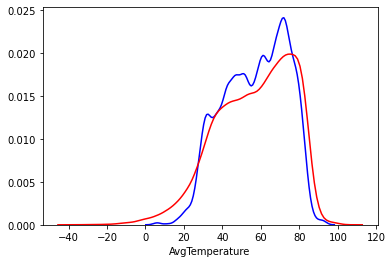

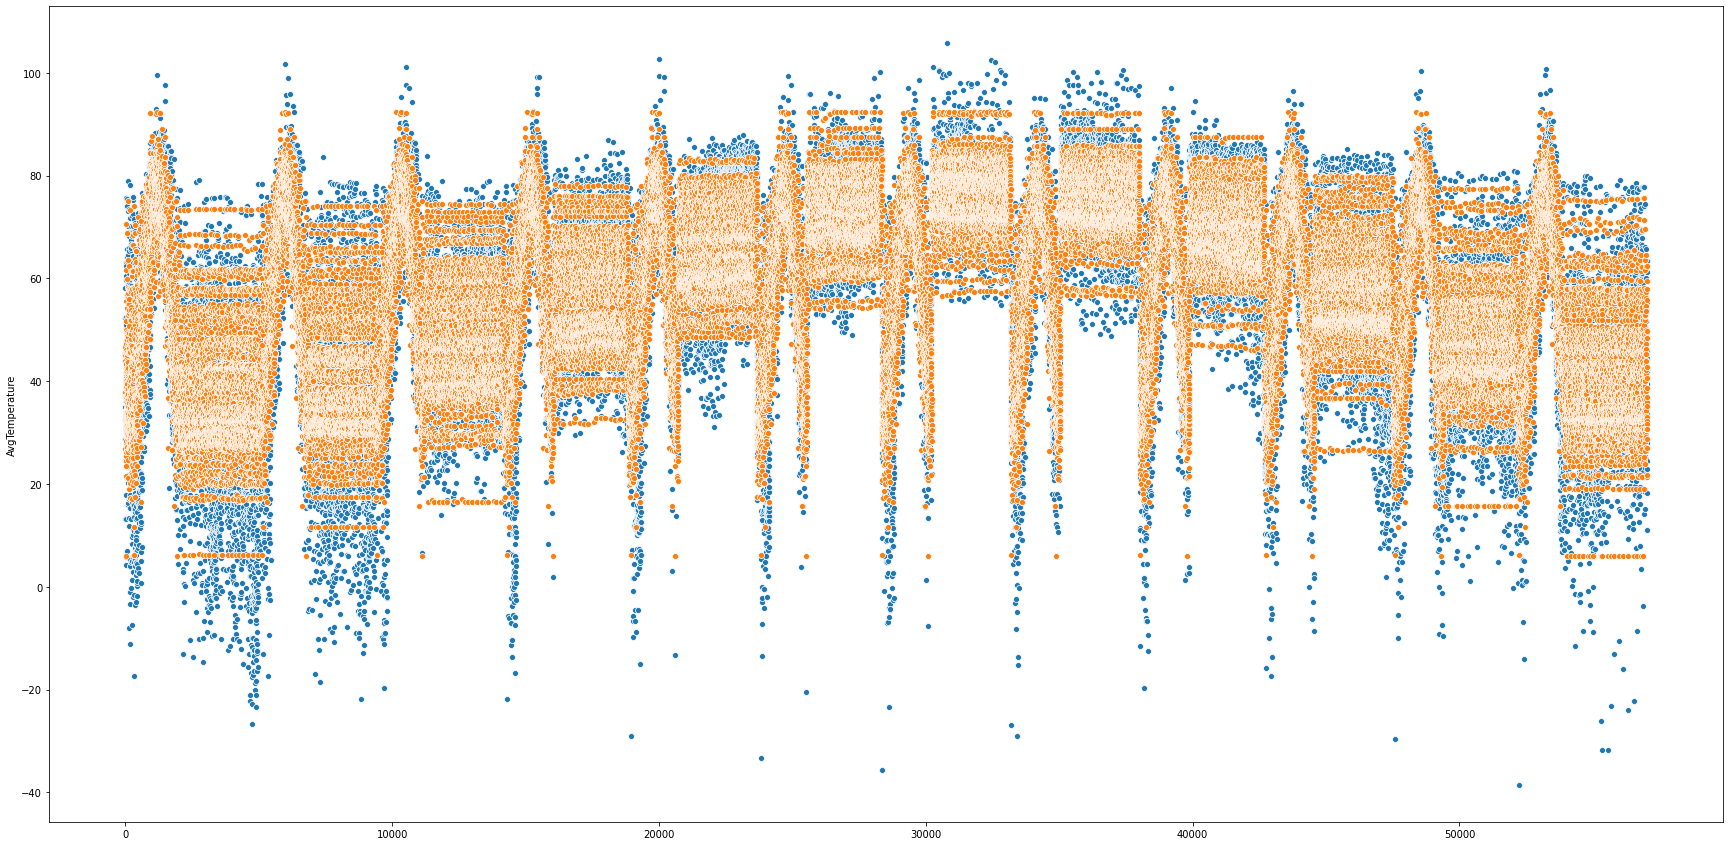

In [24]:
pred = model.predict(x_test[selected])
rmse = sqrt(mean_squared_error(y_test, pred))
print("RMSE : ",rmse)
print("MAE : ",mean_absolute_error(y_test, pred))
sns.distplot(pred, hist=False,color='b')
sns.distplot(y_test, hist=False,color='r')
plt.figure(figsize=(30,15))
sns.scatterplot(np.arange(y_test.shape[0]),y_test)
sns.scatterplot(np.arange(y_test.shape[0]),pred)

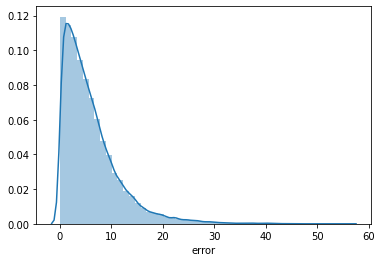

In [25]:
result = pd.DataFrame()
result = x_test
result['actual'] = y_test
result['predicted'] = pred
result['error'] = np.abs(result.actual-result.predicted)
sns.distplot(result.error)

In [26]:
print("SPOT ON % : ",result[result.predicted.astype(int)==result.actual.astype(int)].shape[0]/result.shape[0]*100)
print("+-3 % : ",result[result.error<=3].shape[0]/result.shape[0]*100)
print("+-5 % : ",result[result.error<=5].shape[0]/result.shape[0]*100)
print("+-7 % : ",result[result.error<=7].shape[0]/result.shape[0]*100)
print("+-10 % : ",result[result.error<=10].shape[0]/result.shape[0]*100)

SPOT ON % :  5.768387832032962
+-3 % :  34.50162181116858
+-5 % :  53.28657841676164
+-7 % :  68.1055492241606
+-10 % :  82.45638642938546


In [27]:
import joblib
joblib.dump(model,"modelNA.pkl")

['modelNA.pkl']